## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import warnings
warnings.filterwarnings('ignore')
from operator import itemgetter
import json

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## Path

In [124]:
input_path=r'C:\Users\rishabh.saxena\Desktop\CaseStudy\Raw_data' #base directory
output_path=r'C:\Users\rishabh.saxena\Desktop\CaseStudy\Final_clean_dataset' #base directory
folders=os.listdir(input_path) # list of all folders inside base directory

## 1. Data Preparation

#### Taking median, mean, peak load sensor values from csv data 

In [4]:
def csv_features_creation(df):    
    # Adding new column filename
    df['filename'] = os.path.basename(file) 
    df['filename'] = df['filename'].str.replace('.csv','')
    # Creating features such as median, mean and peak load sensor value
    df['median_lc0'] = df.groupby('filename').lc0.transform('median').astype('int')
    df['median_lc1'] = df.groupby('filename').lc1.transform('median').astype('int')
    df['median_lc2'] = df.groupby('filename').lc2.transform('median').astype('int')
    df['median_lc3'] = df.groupby('filename').lc3.transform('median').astype('int')
    df['mean_sum'] = df.groupby('filename')['sum'].transform('mean').astype('int')
    df['median_sum'] = df.groupby('filename')['sum'].transform('median').astype('int')
    df['peak_sum'] = df.groupby('filename')['sum'].transform('max').astype('int')
    # creating column event duration 
    df['event_duration'] = df.groupby('filename').timestamp.transform('max')
    return df

#### Handling Free Text column to get activity start and end time duration 

In [6]:
def cleaning_free_text(df):
    # Replacing nan values and empty string with '0'
    df['Free_text'] = df['Free_text'].replace(np.nan,'0') 
    df['Free_text'] = df['Free_text'].replace('','0')
    # extracting time values from free text string
    df['Free_text1'] = df['Free_text'].str.findall('([0-1]?[0-9]|2[0-3]):([0-5][0-9]):([0-5][0-9])')
    return df


In [7]:
def add_activity_duration(df):
    # assigning null values when free text dont have two different time values
    if df[df["Free_text1"].str.len()==2].empty:
        df["activity_start_time"]= np.nan
        df["activity_end_time"]= np.nan
        df["activity_duration"]= np.nan
        #changing column datatype to datetime   
        df["activity_start_time"] = pd.to_datetime(df["activity_start_time"])
        df["activity_end_time"] = pd.to_datetime(df["activity_end_time"])
        df["activity_duration"] = pd.to_datetime(df["activity_duration"])
    else:
        # assigning activity start time, end time, duration if two time values are present in free text
        df['activity_start_time'] = df['Free_text1'].transform({'activity_start_time': itemgetter(0)})
        df['activity_end_time'] = df['Free_text1'].transform({'activity_end_time': itemgetter(1)})
        # changing column datatype to datetime   
        df['activity_start_time'] = pd.to_datetime(df['activity_start_time'].agg(':'.join))
        df['activity_end_time'] = pd.to_datetime(df['activity_end_time'].agg(':'.join))
        # creating activity duration in sec
        df['activity_duration'] = (df['activity_end_time']-df['activity_start_time'])/ np.timedelta64(1, 's')
    return(df)

In [8]:
def add_sampling_time(df):
    # creating sampling time using event start time and timestamp columns
    df['Event_start_time'] = df['Event_start_time'].dt.tz_localize(None)
    df['sampling_time'] = df['Event_start_time'].astype('int64') / 10**9
    df['sampling_time'] = df['sampling_time']+df['timestamp']
    df['sampling_time'] = pd.to_datetime(df['sampling_time'], unit='s', origin='unix')
    df['sampling_time'] = df['sampling_time'].dt.time
    return df

#### Adding new features such as mean, peak activity sum to get load sensor values during cat activity 

In [9]:
def add_activity_features(df):
    filtered_df=pd.DataFrame()
    # capturing mean, median and peak load sensor values during activity
    if df[df['activity_start_time'].isnull()].empty:
        start_time = df['activity_start_time'].unique()[0]
        end_time = df['activity_end_time'].unique()[0]
        filtered_df = df[(df['sampling_time']>=start_time) & (df['sampling_time']<=end_time)]

        df['mean_activity_sum']=filtered_df['sum'].mean()
        df['median_activity_sum']=filtered_df['sum'].median()        
        df['peak_activity_sum']=filtered_df['sum'].max()
    else:
        df['mean_activity_sum']=np.nan
        df['median_activity_sum']=np.nan
        df['peak_activity_sum']=np.nan
    return df

In [10]:
final_dataset=pd.DataFrame()
for folder_name in folders:
    folder_path=os.path.join(input_path,folder_name)
    
    all_files_names = os.listdir(folder_path) # list of all the files inside a folder
    unique_file_name=[filename[:-4] for filename in all_files_names if filename.endswith('.csv')]
    folder_data=pd.DataFrame()
    for file in unique_file_name:
#         print(file)
        file_path=os.path.join(folder_path,file)
        event_csv_data = pd.read_csv(file_path+'.csv') # reading csv 
        
        event_csv_data=csv_features_creation(event_csv_data)
                
        event_json_data = pd.read_json(file_path+'.json',lines=True) # reading json file
        
        for i in event_json_data.Tags.values.tolist()[0]: # from Tags list filtering only urination, elimination and non-elimination activity 
            if i in ['urination', 'defecation', 'non_elimination']:
                tag=i
        event_json_data['Tags']=tag
        event_json_data['Target'] = [0 if x =='non_elimination' else 1 for x in event_json_data['Tags']] # Elimination=1 and non_elimination=0
        
        event_json_data = cleaning_free_text(event_json_data)
        
        event_json_data = add_activity_duration(event_json_data)       
        
        # joining an event's csv and json data 
        event_full_data=pd.merge(event_csv_data, event_json_data, left_on='filename', right_on='Event_ID', how='left').drop('filename', axis=1)
        
        # extracting time part from datetime 
        event_full_data['activity_start_time']=event_full_data['activity_start_time'].dt.time
        event_full_data['activity_end_time']=event_full_data['activity_end_time'].dt.time
        
        event_full_data = add_sampling_time(event_full_data)
        
        event_full_data = add_activity_features(event_full_data)

        # event_full_data['Tare_weight']=event_full_data['Tare_weight'].astype(str)
        # drop unnecessary columns and extracting only one row from whole data     
        event_full_data = event_full_data.drop(['t','lc0','lc1','lc2','lc3','sum','timestamp','sampling_time','Free_text1','Tare_weight'],axis=1).drop_duplicates(keep='first')
        
        folder_data = folder_data.append(event_full_data)
    
    final_dataset = final_dataset.append(folder_data)

### Decisions on data selection

- Every Folder is correspond to unique Device_ID and each device has multiple events(Event_IDs).
#### From CSV Data
##### Features Taken: median_lc0, median_lc1, median_lc2, median_lc3, median_sum, max_sum, event_duration    
- In each event, There are multiple recordings of load sensor values so to extract one reading from csv data, I took median load sensor value.
- Features like Mean and Peak sum values are extracted from csv data
- Event duration is whole duration of timestamp value.

#### From Json data
##### Features Taken: Device_ID, Event_ID, Event_start_time, Tags, Weight_of_cat, Name_of_cat
##### Derived Features: activity start and end time, activity duration, mean_activity_sum, median_activity_sum, max_activity_sum, Target 
- Extracted Tags(Urination, defecation and non_elimination) and Target 
- From the Free Text column (activity start and end time is given) acitivity duration is calculated.
- Mean_activity_sum, median_activity_sum and max_activity_sum is extracted by mapping load sensor data using activity start and end time 

### Decisions on merging the data, joining key

- In the device folder, each event has one csv and json file 
- Event_ID column is created in the csv file and json already has Event_ID as column
- Merging is done for event_csv and event_json file, Event_ID as joining key and left merge is done

###  Decisions on the target variable 

- In the final dataset, Tags column have target activities such as elimination(urination and defecation) and non-elimination
- Target column is derived from tags ('1': elimination and '0': non-elimination) 

In [11]:
final_dataset.head()

,median_lc0,median_lc1,median_lc2,median_lc3,mean_sum,median_sum,peak_sum,event_duration,Device_ID,Event_ID,Event_start_time,Tags,Free_text,Name_of_cat,Weight_of_cat,Target,activity_start_time,activity_end_time,activity_duration,mean_activity_sum,median_activity_sum,peak_activity_sum
0,2969,2430,4511,-1695,10112,8214,16035,151.974936,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0OWQ4M2I3MS1kNDZmLTRiYjMtODJkYy1kMTE0MDg4OTBkOGQ=,2020-09-05 10:56:11,urination,0,Ryan,6589,1,NaT,NaT,NaT,NaN,NaN,NaN
0,3038,2699,3622,-2523,10049,6825,14962,111.975000,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0YmI3ZDc5YS0wNzMwLTQ0MTUtYjFmOC0xMDdlNWI0ODNhY2Y=,2020-07-18 14:41:37,urination,"14:42:15\t14:43:09\tConfirmed activity, cat in the box, urination",Ryan,6935,1,14:42:15,14:43:09,54.0,8700.408144,6803.0,14962.0
0,1434,4082,2966,395,11050,8875,15311,102.374944,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0ZTBhMDVhOC0wZmI2LTQ2MGMtYmRiNC1jMWRlZGI5MmM3M2M=,2020-09-03 15:43:43,urination,0,Ryan,5139,1,NaT,NaT,NaT,NaN,NaN,NaN
0,2761,2589,2888,557,9855,8795,16092,66.374940,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo1NGEwMTg2My01NDhjLTRhYTctYjA4YS01ZjZmMGUzNmZjMjc=,2020-09-01 12:02:05,non_elimination,0,Ryan,6983,0,NaT,NaT,NaT,NaN,NaN,NaN
0,2046,2808,3277,272,8927,11513,12523,82.375000,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo1YzQwMzE4MS1lNzhkLTQ3NzMtOWI2Zi02YzcwODkzMDU1NGQ=,2020-08-08 06:47:11,urination,"6:47:16\t6:48:59\tConfirmed activity, cat in the box, urination",Ryan,7017,1,06:47:16,06:48:59,103.0,8751.036822,11511.0,12523.0


In [12]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13075 entries, 0 to 0
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   median_lc0           13075 non-null  int32         
 1   median_lc1           13075 non-null  int32         
 2   median_lc2           13075 non-null  int32         
 3   median_lc3           13075 non-null  int32         
 4   mean_sum             13075 non-null  int32         
 5   median_sum           13075 non-null  int32         
 6   peak_sum             13075 non-null  int32         
 7   event_duration       13075 non-null  float64       
 8   Device_ID            13075 non-null  object        
 9   Event_ID             13075 non-null  object        
 10  Event_start_time     13075 non-null  datetime64[ns]
 11  Tags                 13075 non-null  object        
 12  Free_text            13075 non-null  object        
 13  Name_of_cat          12829 non-null

In [13]:
final_dataset.describe()

,median_lc0,median_lc1,median_lc2,median_lc3,mean_sum,median_sum,peak_sum,event_duration,Weight_of_cat,Target,mean_activity_sum,median_activity_sum,peak_activity_sum
count,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,7804.000000,7804.000000,7804.000000
mean,2702.210860,2500.442141,2724.543021,2788.306616,11578.754570,11567.093996,15126.910669,112.914337,4808.845889,0.682753,13005.374094,13371.675935,14939.599052
std,2016.246018,1671.249988,1967.043804,1877.289976,3656.719116,4178.355452,3775.458159,58.472873,999.232091,0.465422,3741.490970,3864.364258,3953.790338
min,-3226.000000,-1838.000000,-4242.000000,-2862.000000,-532.000000,-771.000000,141.000000,3.983949,0.000000,0.000000,53.272222,-577.000000,141.000000
25%,1319.000000,1340.500000,1481.000000,1574.000000,9159.000000,8764.500000,12528.000000,74.374931,4177.000000,0.000000,10705.084433,11016.500000,12354.750000
50%,2514.000000,2438.000000,2771.000000,2722.000000,11331.000000,11383.000000,14920.000000,105.928439,4651.000000,1.000000,12624.604757,13116.000000,14735.000000
75%,3986.500000,3591.000000,4105.000000,3892.000000,13659.500000,14384.000000,17325.000000,140.805793,5500.000000,1.000000,15028.791671,15527.250000,17237.000000
max,10256.000000,10058.000000,9848.000000,11758.000000,22810.000000,24375.000000,46803.000000,669.461843,21875.000000,1.000000,24261.533056,24448.000000,33226.000000


In [14]:
final_dataset.head()

,median_lc0,median_lc1,median_lc2,median_lc3,mean_sum,median_sum,peak_sum,event_duration,Device_ID,Event_ID,Event_start_time,Tags,Free_text,Name_of_cat,Weight_of_cat,Target,activity_start_time,activity_end_time,activity_duration,mean_activity_sum,median_activity_sum,peak_activity_sum
0,2969,2430,4511,-1695,10112,8214,16035,151.974936,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0OWQ4M2I3MS1kNDZmLTRiYjMtODJkYy1kMTE0MDg4OTBkOGQ=,2020-09-05 10:56:11,urination,0,Ryan,6589,1,NaT,NaT,NaT,NaN,NaN,NaN
0,3038,2699,3622,-2523,10049,6825,14962,111.975000,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0YmI3ZDc5YS0wNzMwLTQ0MTUtYjFmOC0xMDdlNWI0ODNhY2Y=,2020-07-18 14:41:37,urination,"14:42:15\t14:43:09\tConfirmed activity, cat in the box, urination",Ryan,6935,1,14:42:15,14:43:09,54.0,8700.408144,6803.0,14962.0
0,1434,4082,2966,395,11050,8875,15311,102.374944,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0ZTBhMDVhOC0wZmI2LTQ2MGMtYmRiNC1jMWRlZGI5MmM3M2M=,2020-09-03 15:43:43,urination,0,Ryan,5139,1,NaT,NaT,NaT,NaN,NaN,NaN
0,2761,2589,2888,557,9855,8795,16092,66.374940,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo1NGEwMTg2My01NDhjLTRhYTctYjA4YS01ZjZmMGUzNmZjMjc=,2020-09-01 12:02:05,non_elimination,0,Ryan,6983,0,NaT,NaT,NaT,NaN,NaN,NaN
0,2046,2808,3277,272,8927,11513,12523,82.375000,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo1YzQwMzE4MS1lNzhkLTQ3NzMtOWI2Zi02YzcwODkzMDU1NGQ=,2020-08-08 06:47:11,urination,"6:47:16\t6:48:59\tConfirmed activity, cat in the box, urination",Ryan,7017,1,06:47:16,06:48:59,103.0,8751.036822,11511.0,12523.0


## 2. Feature Engineering

- To capture the day part of event, day is divided int0 6 parts(Late Night, Early Morning, Morning, Noon, Evening, Night)
- Power and energy values is extracted from load sensor data.
- Power and Energy values for time series data is directly proportional to square of load sensor values.

In [16]:
final_dataset['Day_Part'] = (final_dataset['Event_start_time'].dt.hour + 4) // 4
final_dataset['Day_Part'].replace({1: 'Late Night',2: 'Early Morning',3: 'Morning',4: 'Noon',5: 'Evening',6: 'Night'},inplace=True)

In [17]:
final_dataset['max_l'] = final_dataset[['median_lc0', 'median_lc1','median_lc2','median_lc3']].values.max(1)

In [18]:
final_dataset['power_1']=((final_dataset['median_lc0']/max(final_dataset['max_l']))**2)
final_dataset['power_2']=((final_dataset['median_lc1']/max(final_dataset['max_l']))**2)
final_dataset['power_3']=((final_dataset['median_lc2']/max(final_dataset['max_l']))**2)
final_dataset['power_4']=((final_dataset['median_lc3']/max(final_dataset['max_l']))**2)
final_dataset['power']=final_dataset['power_1']+final_dataset['power_2']+final_dataset['power_3']+final_dataset['power_4']

In [19]:
final_dataset['energy']=(final_dataset['power'])*(final_dataset['event_duration'])

In [20]:
final_dataset.head()

,median_lc0,median_lc1,median_lc2,median_lc3,mean_sum,median_sum,peak_sum,event_duration,Device_ID,Event_ID,Event_start_time,Tags,Free_text,Name_of_cat,Weight_of_cat,Target,activity_start_time,activity_end_time,activity_duration,mean_activity_sum,median_activity_sum,peak_activity_sum,Day_Part,max_l,power_1,power_2,power_3,power_4,power,energy
0,2969,2430,4511,-1695,10112,8214,16035,151.974936,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0OWQ4M2I3MS1kNDZmLTRiYjMtODJkYy1kMTE0MDg4OTBkOGQ=,2020-09-05 10:56:11,urination,0,Ryan,6589,1,NaT,NaT,NaT,NaN,NaN,NaN,Morning,4511,0.063761,0.042712,0.147190,0.020781,0.274444,41.708575
0,3038,2699,3622,-2523,10049,6825,14962,111.975000,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0YmI3ZDc5YS0wNzMwLTQ0MTUtYjFmOC0xMDdlNWI0ODNhY2Y=,2020-07-18 14:41:37,urination,"14:42:15\t14:43:09\tConfirmed activity, cat in the box, urination",Ryan,6935,1,14:42:15,14:43:09,54.0,8700.408144,6803.0,14962.0,Noon,3622,0.066759,0.052691,0.094892,0.046043,0.260386,29.156679
0,1434,4082,2966,395,11050,8875,15311,102.374944,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0ZTBhMDVhOC0wZmI2LTQ2MGMtYmRiNC1jMWRlZGI5MmM3M2M=,2020-09-03 15:43:43,urination,0,Ryan,5139,1,NaT,NaT,NaT,NaN,NaN,NaN,Noon,4082,0.014874,0.120526,0.063632,0.001129,0.200160,20.491390
0,2761,2589,2888,557,9855,8795,16092,66.374940,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo1NGEwMTg2My01NDhjLTRhYTctYjA4YS01ZjZmMGUzNmZjMjc=,2020-09-01 12:02:05,non_elimination,0,Ryan,6983,0,NaT,NaT,NaT,NaN,NaN,NaN,Noon,2888,0.055140,0.048484,0.060329,0.002244,0.166197,11.031319
0,2046,2808,3277,272,8927,11513,12523,82.375000,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo1YzQwMzE4MS1lNzhkLTQ3NzMtOWI2Zi02YzcwODkzMDU1NGQ=,2020-08-08 06:47:11,urination,"6:47:16\t6:48:59\tConfirmed activity, cat in the box, urination",Ryan,7017,1,06:47:16,06:48:59,103.0,8751.036822,11511.0,12523.0,Early Morning,3277,0.030279,0.057033,0.077676,0.000535,0.165523,13.634984


In [32]:
filter_data=final_dataset.drop(['Event_start_time','Free_text','activity_start_time','activity_end_time','max_l','power_1','power_2','power_3','power_4'],axis=1)

### Data Cleaning

In [23]:
filter_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13075 entries, 0 to 0
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   median_lc0           13075 non-null  int32  
 1   median_lc1           13075 non-null  int32  
 2   median_lc2           13075 non-null  int32  
 3   median_lc3           13075 non-null  int32  
 4   mean_sum             13075 non-null  int32  
 5   median_sum           13075 non-null  int32  
 6   peak_sum             13075 non-null  int32  
 7   event_duration       13075 non-null  float64
 8   Device_ID            13075 non-null  object 
 9   Event_ID             13075 non-null  object 
 10  Tags                 13075 non-null  object 
 11  Name_of_cat          12829 non-null  object 
 12  Weight_of_cat        13075 non-null  int64  
 13  Target               13075 non-null  int64  
 14  activity_duration    8814 non-null   object 
 15  mean_activity_sum    7804 non-null   flo

### Handling Null Values 

In [33]:
filter_data['activity_duration'] = filter_data['activity_duration'].fillna(value=0)
filter_data['mean_activity_sum'] = filter_data['mean_activity_sum'].fillna(value=0)
filter_data['median_activity_sum'] = filter_data['median_activity_sum'].fillna(value=0)
filter_data['peak_activity_sum'] = filter_data['peak_activity_sum'].fillna(value=0)

In [34]:
columns=['event_duration','activity_duration','mean_activity_sum','median_activity_sum','peak_activity_sum','energy']

In [40]:
filter_data[columns] = filter_data[columns].astype('int64')

In [36]:
filter_data['activity_duration']=filter_data['activity_duration'].replace(to_replace=0,value=np.nan)
filter_data['mean_activity_sum']=filter_data['mean_activity_sum'].replace(to_replace=0,value=np.nan)
filter_data['median_activity_sum']=filter_data['median_activity_sum'].replace(to_replace=0,value=np.nan)
filter_data['peak_activity_sum']=filter_data['peak_activity_sum'].replace(to_replace=0,value=np.nan)

In [37]:
filter_df=filter_data[['activity_duration','mean_activity_sum','median_activity_sum','peak_activity_sum','Target','event_duration','mean_sum','median_sum','energy']]

#### KNN imputer is used to identify and replace missing values for given columns
- a point value can be approximated by the values of the points that are closest, based on other variables.

In [38]:
from sklearn.impute import KNNImputer
impute_knn = KNNImputer(n_neighbors=5)
filter_data[['activity_duration','mean_activity_sum','median_activity_sum','peak_activity_sum','Target','event_duration','mean_sum','median_sum','energy']]=impute_knn.fit_transform(filter_df)

In [41]:
filter_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13075 entries, 0 to 0
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   median_lc0           13075 non-null  int32  
 1   median_lc1           13075 non-null  int32  
 2   median_lc2           13075 non-null  int32  
 3   median_lc3           13075 non-null  int32  
 4   mean_sum             13075 non-null  float64
 5   median_sum           13075 non-null  float64
 6   peak_sum             13075 non-null  int32  
 7   event_duration       13075 non-null  int64  
 8   Device_ID            13075 non-null  object 
 9   Event_ID             13075 non-null  object 
 10  Tags                 13075 non-null  object 
 11  Name_of_cat          12829 non-null  object 
 12  Weight_of_cat        13075 non-null  int64  
 13  Target               13075 non-null  float64
 14  activity_duration    13075 non-null  int64  
 15  mean_activity_sum    13075 non-null  int

In [42]:
filter_data.head()

,median_lc0,median_lc1,median_lc2,median_lc3,mean_sum,median_sum,peak_sum,event_duration,Device_ID,Event_ID,Tags,Name_of_cat,Weight_of_cat,Target,activity_duration,mean_activity_sum,median_activity_sum,peak_activity_sum,Day_Part,power,energy
0,2969,2430,4511,-1695,10112.0,8214.0,16035,151,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0OWQ4M2I3MS1kNDZmLTRiYjMtODJkYy1kMTE0MDg4OTBkOGQ=,urination,Ryan,6589,1.0,45,10521,10991,15866,Morning,0.274444,41
0,3038,2699,3622,-2523,10049.0,6825.0,14962,111,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0YmI3ZDc5YS0wNzMwLTQ0MTUtYjFmOC0xMDdlNWI0ODNhY2Y=,urination,Ryan,6935,1.0,54,8700,6803,14962,Noon,0.260386,29
0,1434,4082,2966,395,11050.0,8875.0,15311,102,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0ZTBhMDVhOC0wZmI2LTQ2MGMtYmRiNC1jMWRlZGI5MmM3M2M=,urination,Ryan,5139,1.0,48,13323,14093,14945,Noon,0.200160,20
0,2761,2589,2888,557,9855.0,8795.0,16092,66,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo1NGEwMTg2My01NDhjLTRhYTctYjA4YS01ZjZmMGUzNmZjMjc=,non_elimination,Ryan,6983,0.0,36,10612,10744,12401,Noon,0.166197,11
0,2046,2808,3277,272,8927.0,11513.0,12523,82,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo1YzQwMzE4MS1lNzhkLTQ3NzMtOWI2Zi02YzcwODkzMDU1NGQ=,urination,Ryan,7017,1.0,103,8751,11511,12523,Early Morning,0.165523,13


### Outlier Handling

In [43]:
def plotvariable(data,variable):
    plt.figure(figsize=(12,7))
    #histogram
    plt.subplot(1,2,1)
    plt.hist(data[variable],alpha=0.5)
    #boxplot
    plt.subplot(1,2,2)
    sns.boxplot(data[variable])
    plt.show()

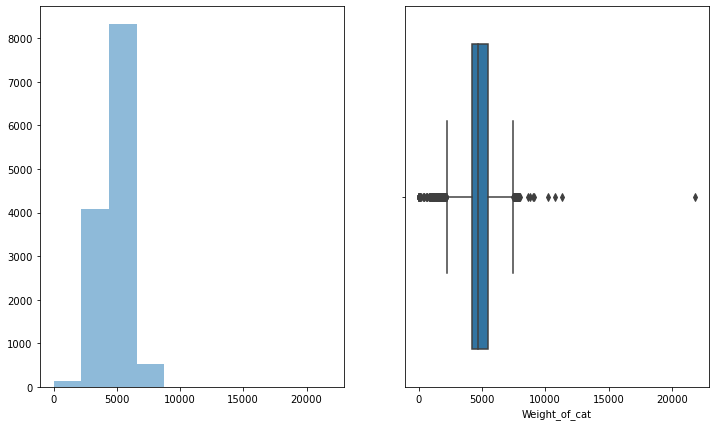

In [44]:
plotvariable(filter_data,'Weight_of_cat')

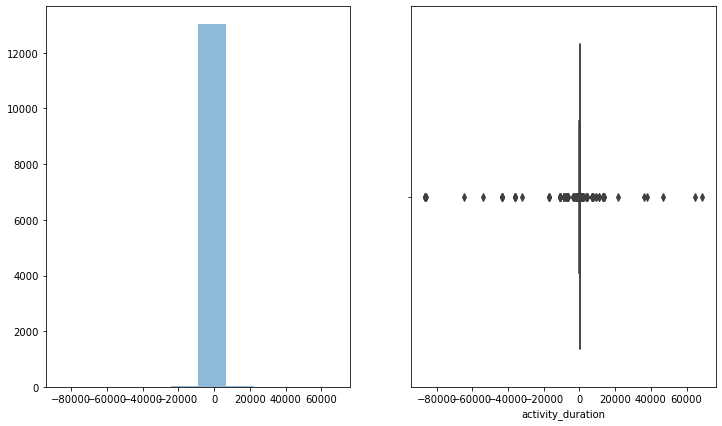

In [45]:
plotvariable(filter_data,'activity_duration')

- As we can notice that data is not following normal distribution for 'weight of cat' and 'activity duration' 

In [46]:
filter_data.describe()

,median_lc0,median_lc1,median_lc2,median_lc3,mean_sum,median_sum,peak_sum,event_duration,Weight_of_cat,Target,activity_duration,mean_activity_sum,median_activity_sum,peak_activity_sum,power,energy
count,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000
mean,2702.210860,2500.442141,2724.543021,2788.306616,11578.754570,11567.093996,15126.910669,112.370249,4808.845889,0.682753,-13.719541,12779.180650,13161.144627,14807.685736,0.311049,35.647419
std,2016.246018,1671.249988,1967.043804,1877.289976,3656.719116,4178.355452,3775.458159,58.463329,999.232091,0.465422,2642.942104,3627.805174,3739.573759,3790.121296,0.183487,32.602804
min,-3226.000000,-1838.000000,-4242.000000,-2862.000000,-532.000000,-771.000000,141.000000,3.000000,0.000000,0.000000,-86376.000000,53.000000,-577.000000,141.000000,0.018104,0.000000
25%,1319.000000,1340.500000,1481.000000,1574.000000,9159.000000,8764.500000,12528.000000,74.000000,4177.000000,0.000000,35.000000,10414.000000,10762.500000,12270.500000,0.184928,14.000000
50%,2514.000000,2438.000000,2771.000000,2722.000000,11331.000000,11383.000000,14920.000000,105.000000,4651.000000,1.000000,55.000000,12515.000000,12891.000000,14715.000000,0.270475,26.000000
75%,3986.500000,3591.000000,4105.000000,3892.000000,13659.500000,14384.000000,17325.000000,140.000000,5500.000000,1.000000,92.000000,14858.000000,15328.500000,17015.500000,0.386766,47.000000
max,10256.000000,10058.000000,9848.000000,11758.000000,22810.000000,24375.000000,46803.000000,669.000000,21875.000000,1.000000,68524.000000,24261.000000,24448.000000,33226.000000,1.227601,489.000000


In [47]:
column=['Weight_of_cat','activity_duration']

#### Detecting the outlier using IQR and imputing with the median value. 

In [48]:
def impute_outliers_IQR(df,variable):
    q1=df[variable].quantile(0.25)
    q3=df[variable].quantile(0.75)
    IQR=q3-q1
    upper = df[variable][~(df[variable]>(q3+1.5*IQR))].max()
    lower = df[variable][~(df[variable]<(q1-1.5*IQR))].min()
    df[variable] = np.where(df[variable]>upper,df[variable].median(),np.where(df[variable]<lower,df[variable].median(),df[variable]))
    return df[variable]

In [49]:
filter_data['Weight_of_cat']=impute_outliers_IQR(filter_data,'Weight_of_cat')
filter_data['activity_duration']=impute_outliers_IQR(filter_data,'activity_duration')

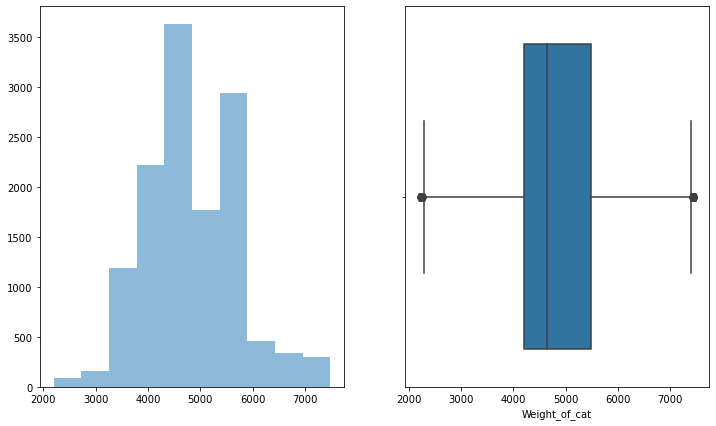

In [50]:
plotvariable(filter_data,'Weight_of_cat')

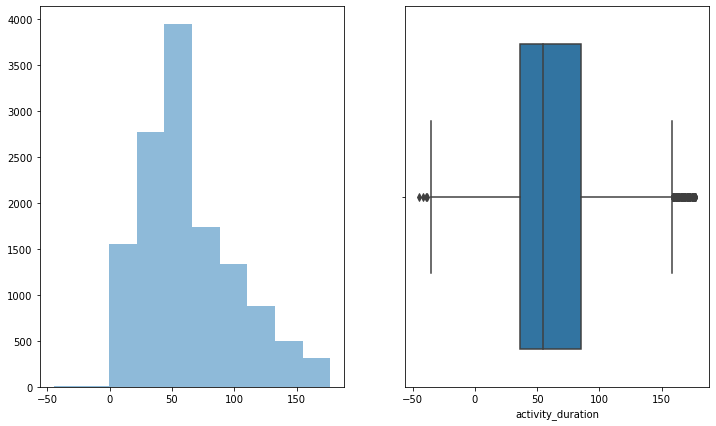

In [51]:
plotvariable(filter_data,'activity_duration')

In [125]:
filter_data.to_csv(path_or_buf=output_path)

## 3. Exploratory Data Analysis(EDA)

In [52]:
sns.set(rc={'figure.figsize':(15,5)})

### Univariate Analysis

In [53]:
df_pair=filter_data[['mean_sum','median_sum','peak_sum','event_duration','Weight_of_cat','activity_duration','mean_activity_sum','median_activity_sum','Target','Tags']]

In [54]:
df_elimi=df_pair.loc[df_pair['Target']==1]
df_non_elimi=df_pair.loc[df_pair['Target']==0]

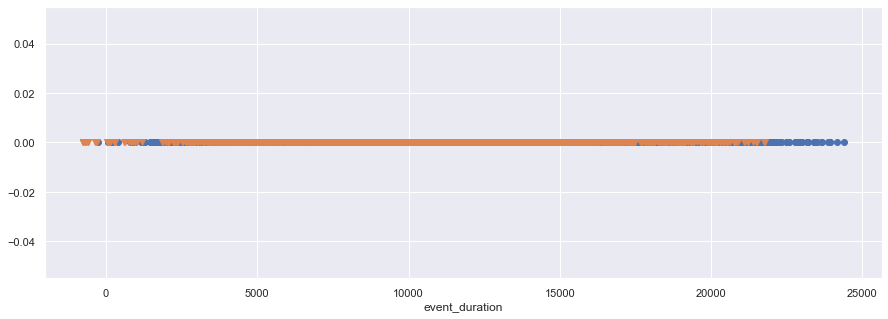

In [55]:
plt.plot(df_elimi['median_sum'],np.zeros_like(df_elimi['median_sum']),'o')
plt.plot(df_non_elimi['median_sum'],np.zeros_like(df_non_elimi['median_sum']),'v')
plt.xlabel('median_sum')
plt.show()

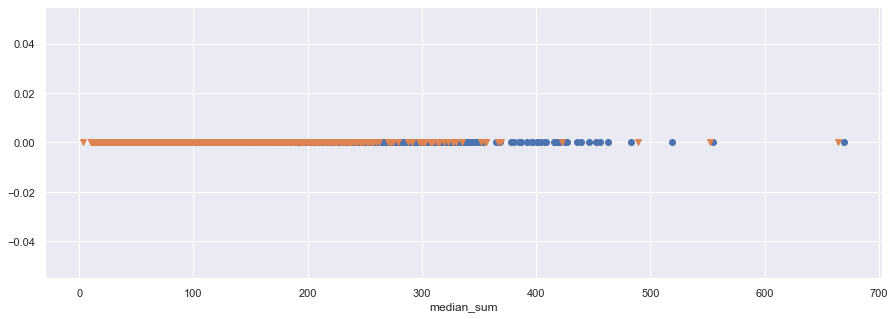

In [56]:
plt.plot(df_elimi['event_duration'],np.zeros_like(df_elimi['event_duration']),'o')
plt.plot(df_non_elimi['event_duration'],np.zeros_like(df_non_elimi['event_duration']),'v')
plt.xlabel('event_duration')
plt.show()

#### Observation:
- load sensor values for elimination activity(approximately 25000 gm) higher than non-elimionation(approximately 22000gm)
- event duration for elimination activity(approximately 500sec) is higher in comparison to non-elimination(approximately 350sec)

###  Explored the support vs time during Cat events

In [57]:
def scatterplot_median(data):
    plt.figure(figsize=(15,12))
    plt.subplot(3, 2, 1)
    sns.scatterplot('median_lc0','event_duration',hue='Tags',style='Target',markers=['o','s',],data=filter_data)
    plt.subplot(3, 2, 2)
    sns.scatterplot('median_lc1','event_duration',hue='Tags',style='Target',markers=['o','s',],data=filter_data)
    plt.subplot(3, 2, 3)
    sns.scatterplot('median_lc2','event_duration',hue='Tags',style='Target',markers=['o','s',],data=filter_data)
    plt.subplot(3, 2, 4)
    sns.scatterplot('median_lc3','event_duration',hue='Tags',style='Target',markers=['o','s',],data=filter_data)
    plt.subplot(3, 2, 5)
    sns.scatterplot('median_sum','event_duration',hue='Tags',style='Target',markers=['o','s',],data=filter_data)
    plt.subplot(3, 2, 6)
    sns.scatterplot('median_activity_sum','event_duration',hue='Tags',style='Target',markers=['o','s',],data=filter_data)
    plt.show()

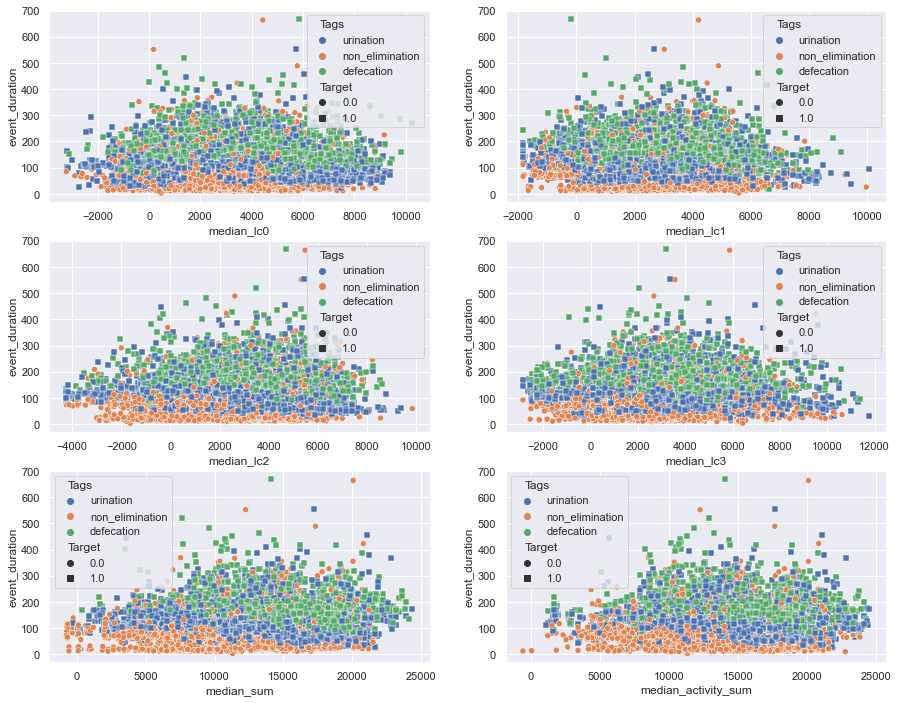

In [58]:
scatterplot_median(filter_data)

#### Observation:
- median sensor data and event_duration are continuous variable so scatter plot will give better insights.
- From Scatter plot it is clear that non_elimination activities at the bottom which means less time is consumed during this activity and at the top defaction activity.
- load sensor data and event duration is showing positive correlation for elimination activities.
- lc2 sensor data is showing more negative readings(median_lc2 vs event duration) 

### Explored the Mean and Peak support values vs activity duration during Cat events

In [59]:
def scatterplot_mean_max(data):
    plt.figure(figsize=(15,12))
    plt.subplot(2, 2, 1)
    sns.scatterplot('mean_sum','activity_duration',hue='Tags',style='Target',markers=['o','s',],data=filter_data)
    plt.subplot(2, 2, 2)
    sns.scatterplot('mean_activity_sum','activity_duration',hue='Tags',style='Target',markers=['o','s',],data=filter_data)
    plt.subplot(2, 2, 3)
    sns.scatterplot('peak_sum','activity_duration',hue='Tags',style='Target',markers=['o','s',],data=filter_data)
    plt.subplot(2, 2, 4)
    sns.scatterplot('peak_activity_sum','activity_duration',hue='Tags',style='Target',markers=['o','s',],data=filter_data)
    plt.show()

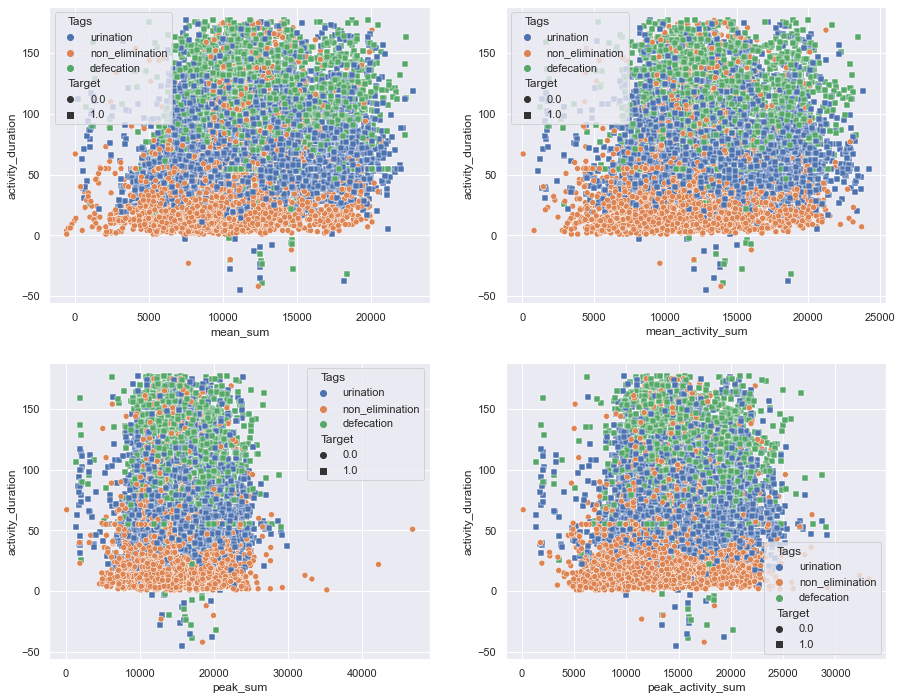

In [60]:
scatterplot_mean_max(filter_data)

### Relationship of load sensors during Elimination and Non-elimination activity 

In [61]:
def boxplot_median(data):
    plt.figure(figsize=(16,12))
    plt.subplot(3, 3, 1)
    sns.boxplot('Target','median_lc0',data=filter_data)
    plt.subplot(3, 3, 2)
    sns.boxplot('Target','median_lc1',data=filter_data)
    plt.subplot(3, 3, 3)
    sns.boxplot('Target','median_lc2',data=filter_data)
    plt.subplot(3, 3, 4)
    sns.boxplot('Target','median_lc3',data=filter_data)
    plt.subplot(3, 3, 5)
    sns.boxplot('Target','median_sum',data=filter_data)
    plt.subplot(3, 3, 6)
    sns.boxplot('Target','median_activity_sum',data=filter_data)
    plt.show()

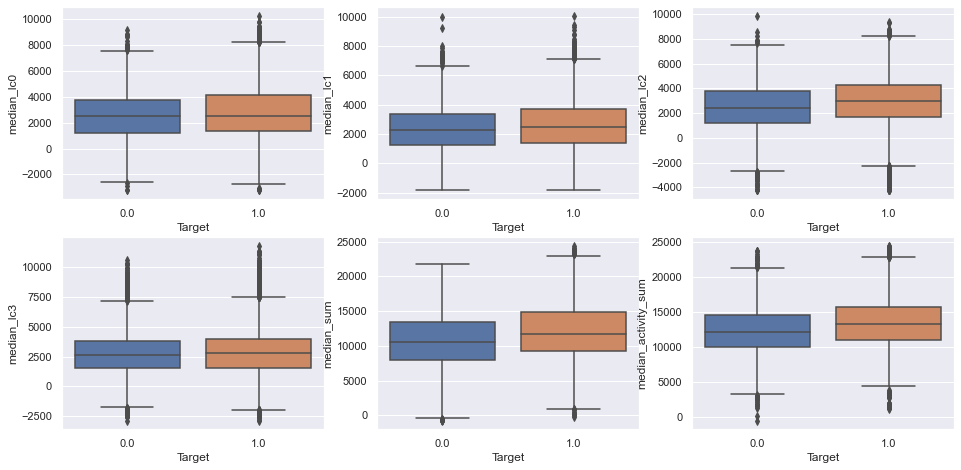

In [62]:
boxplot_median(filter_data)

<AxesSubplot:xlabel='Tags', ylabel='median_sum'>

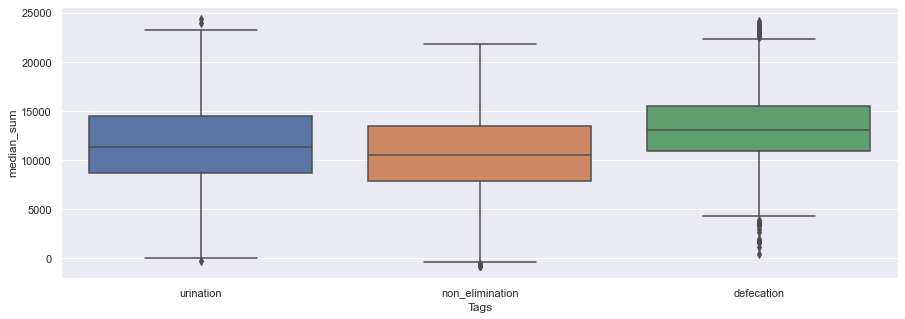

In [66]:
sns.boxplot('Tags','median_sum',data=filter_data)

#### Note:
- for defcecation load sensor value is highest 

In [67]:
def boxplot_mean_max(data):
    plt.figure(figsize=(15,12))
    plt.subplot(2, 2, 1)
    sns.boxplot('Target','mean_sum',data=filter_data)
    plt.subplot(2, 2, 2)
    sns.boxplot('Target','mean_activity_sum',data=filter_data)
    plt.subplot(2, 2, 3)
    sns.boxplot('Target','peak_sum',data=filter_data)
    plt.subplot(2, 2, 4)
    sns.boxplot('Target','peak_activity_sum',data=filter_data)
    plt.show()

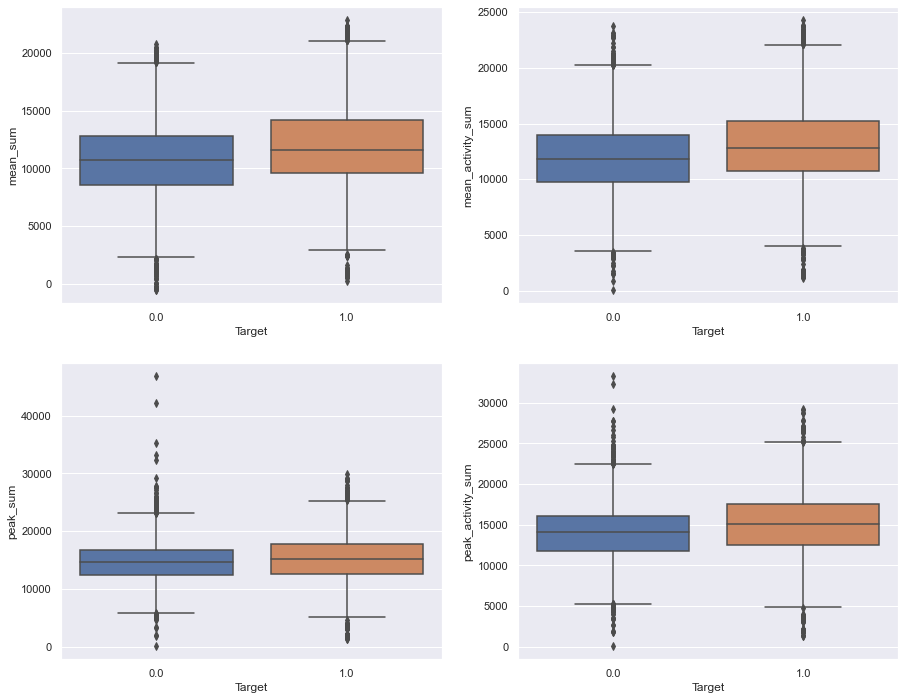

In [68]:
boxplot_mean_max(filter_data)

#### Observation:
- load sensor value for elimination activiy(represented as 1) is higher than non_elimination(represented as 0)

### Relationship of time duration during Elimination and Non-elimination activity 

<AxesSubplot:xlabel='Target', ylabel='event_duration'>

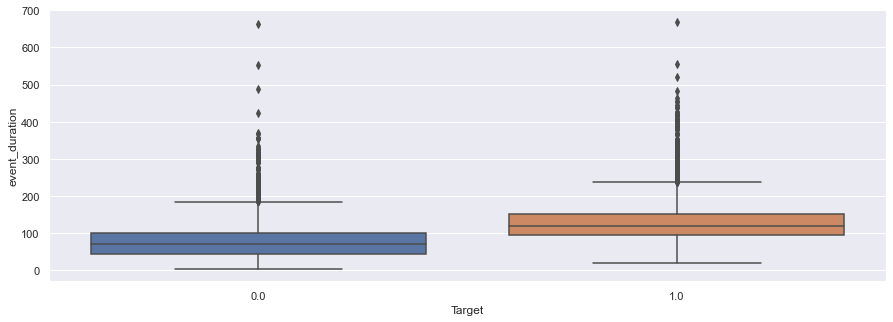

In [69]:
sns.boxplot('Target','event_duration',data=filter_data)

<AxesSubplot:xlabel='Tags', ylabel='event_duration'>

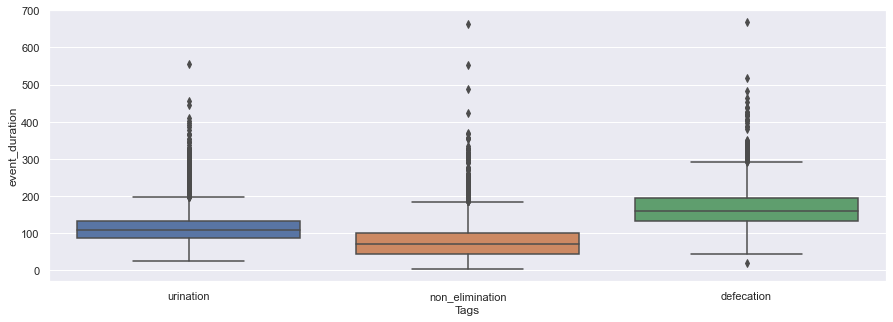

In [70]:
sns.boxplot('Tags','event_duration',data=filter_data)

#### Observations
- event duration for elimination is higher than non_elimination
- for defecation event duration is maximum

<AxesSubplot:xlabel='Target', ylabel='activity_duration'>

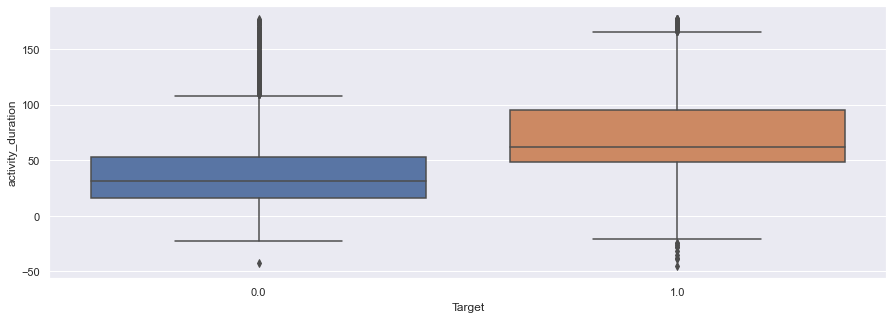

In [71]:
sns.boxplot('Target','activity_duration',data=filter_data)

<AxesSubplot:xlabel='Tags', ylabel='activity_duration'>

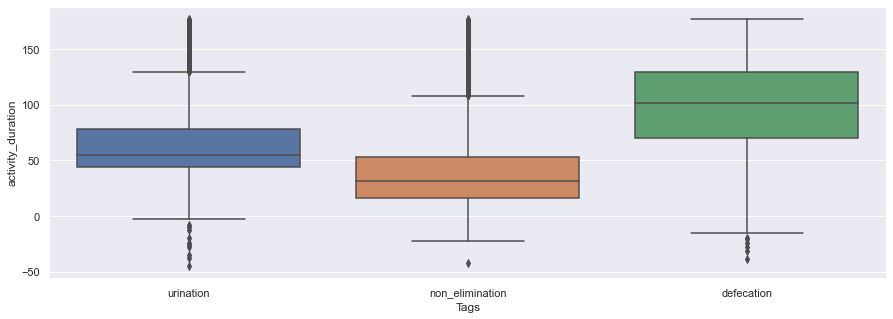

In [72]:
sns.boxplot('Tags','activity_duration',data=filter_data)

#### Note:
- similar to event duration, activity duration is also maximum for defecation activity while lowest for non elimination 

<AxesSubplot:xlabel='event_duration', ylabel='energy'>

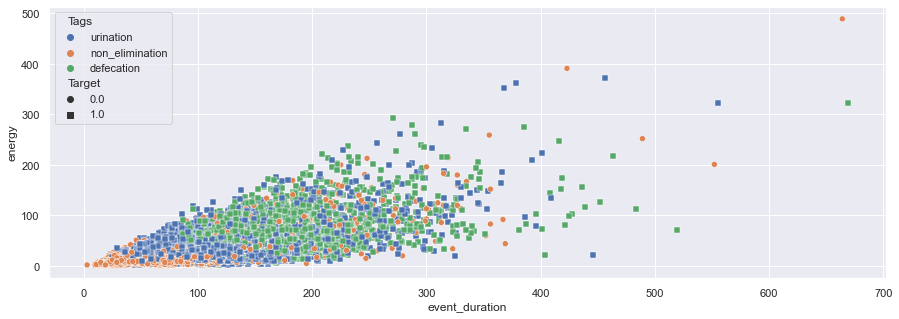

In [75]:
sns.scatterplot('event_duration','energy',hue='Tags',style='Target',markers=['o','s',],data=filter_data)

#### Observation:
- energy values is less for non_elimination activity incomparison with elimination

### Relationship between cat and behaviour pattern

In [76]:
filter_data['Name_of_cat'].nunique()

51

<AxesSubplot:>

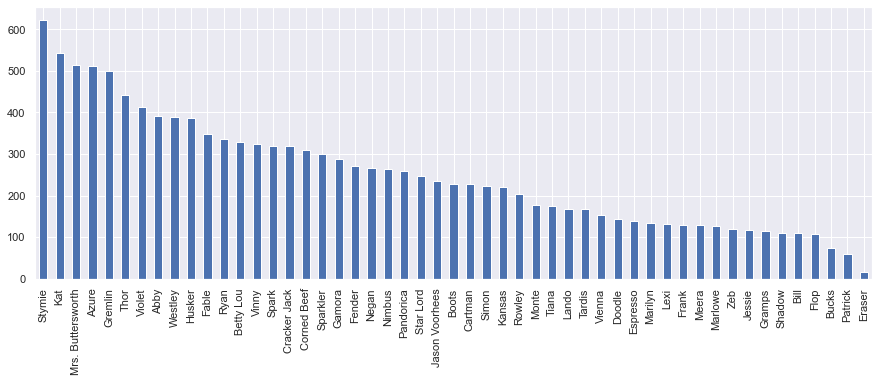

In [78]:
plt.figure(figsize=(15,5))
filter_data['Name_of_cat'].value_counts().plot(kind='bar')

<AxesSubplot:xlabel='Name_of_cat'>

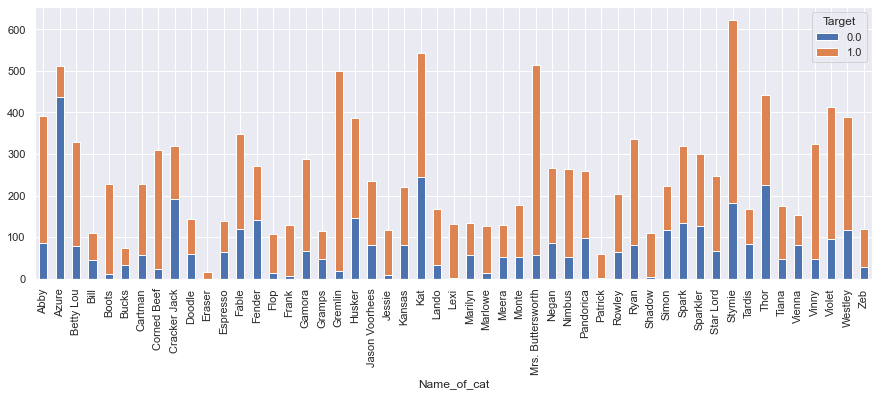

In [80]:
filter_data.groupby(['Name_of_cat', 'Target'])['Name_of_cat'].count().unstack().plot(kind='bar',stacked=True)

<AxesSubplot:xlabel='Name_of_cat'>

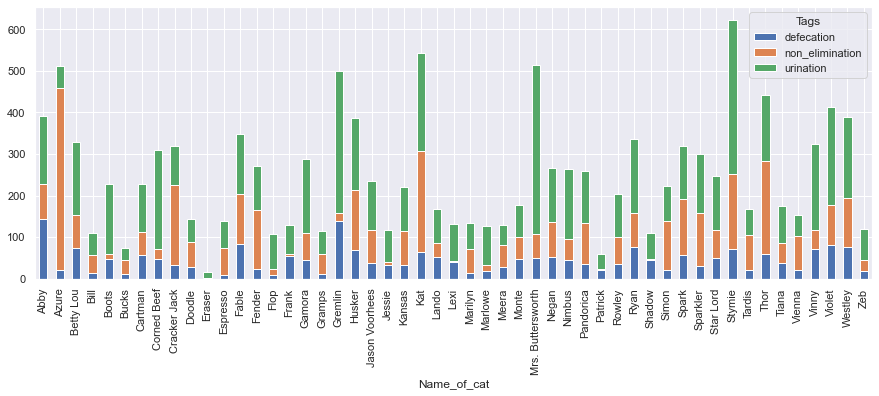

In [81]:
filter_data.groupby(['Name_of_cat', 'Tags'])['Name_of_cat'].count().unstack().plot(kind='bar', stacked=True)

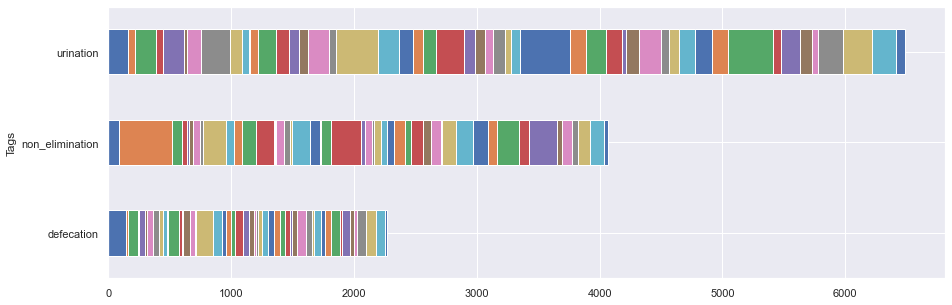

In [79]:
filter_data[['Name_of_cat','Tags']].value_counts().unstack(0).plot(kind='barh',stacked=True)
plt.gca().get_legend().remove()

#### Observation
- Urination is most common activity in cats, followed by non-elimination and defecation

<AxesSubplot:xlabel='Day_Part'>

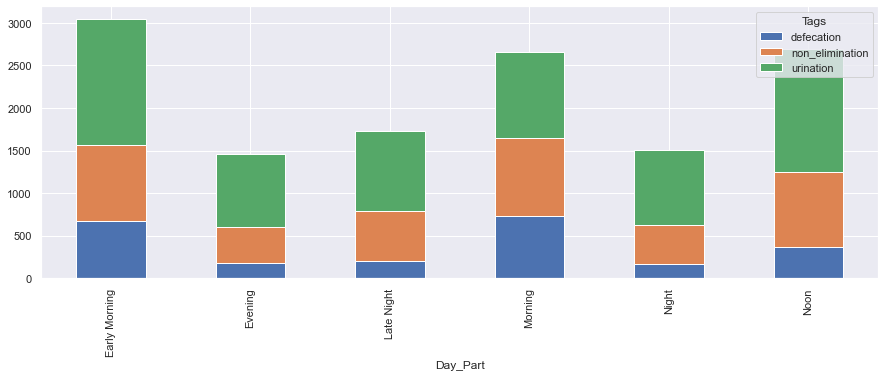

In [82]:
filter_data.groupby(['Day_Part', 'Tags'])['Day_Part'].count().unstack().plot(kind='bar', stacked=True)

### Summary of the patterns for each activity


- When Cat is inside the box load sensor values are maximum (showing flat line) after that sudden dip(cat left the box). 
- Load sensor values and event duration for elimination activity higher than non-elimionation (from univariate analysis)
- From Scatter plot, non_elimination activities at the bottom which means less time is consumed during this and at the top defaction activity.
- Load sensor data and event duration is showing positive correlation for elimination activities.
- lc2 sensor data is showing more negative readings(median_lc2 vs event duration) than other sensors.
- From boxplot between activity duration and Tags, elimination activity is taking more time(defecation particularly)
- Energy time series values are positive correlated with event duration.
- 51 unique cat data is recorded in which 'Stymie' is appeared maximum times.
- Urination activity is most common activity among the cats.
- In day part during early morning and morning time cats are having maximum activity. 

## 4. Model Building

In [83]:
filter_data['Day_Part'].replace({'Late Night':1,'Early Morning':2,'Morning':3,'Noon':4,'Evening':5,'Night':6},inplace=True)

In [84]:
filter_data.head()

,median_lc0,median_lc1,median_lc2,median_lc3,mean_sum,median_sum,peak_sum,event_duration,Device_ID,Event_ID,Tags,Name_of_cat,Weight_of_cat,Target,activity_duration,mean_activity_sum,median_activity_sum,peak_activity_sum,Day_Part,power,energy
0,2969,2430,4511,-1695,10112.0,8214.0,16035,151,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0OWQ4M2I3MS1kNDZmLTRiYjMtODJkYy1kMTE0MDg4OTBkOGQ=,urination,Ryan,6589.0,1.0,45.0,10521,10991,15866,3,0.274444,41
0,3038,2699,3622,-2523,10049.0,6825.0,14962,111,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0YmI3ZDc5YS0wNzMwLTQ0MTUtYjFmOC0xMDdlNWI0ODNhY2Y=,urination,Ryan,6935.0,1.0,54.0,8700,6803,14962,4,0.260386,29
0,1434,4082,2966,395,11050.0,8875.0,15311,102,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0ZTBhMDVhOC0wZmI2LTQ2MGMtYmRiNC1jMWRlZGI5MmM3M2M=,urination,Ryan,5139.0,1.0,48.0,13323,14093,14945,4,0.200160,20
0,2761,2589,2888,557,9855.0,8795.0,16092,66,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo1NGEwMTg2My01NDhjLTRhYTctYjA4YS01ZjZmMGUzNmZjMjc=,non_elimination,Ryan,6983.0,0.0,36.0,10612,10744,12401,4,0.166197,11
0,2046,2808,3277,272,8927.0,11513.0,12523,82,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo1YzQwMzE4MS1lNzhkLTQ3NzMtOWI2Zi02YzcwODkzMDU1NGQ=,urination,Ryan,7017.0,1.0,103.0,8751,11511,12523,2,0.165523,13


In [86]:
model_df=filter_data.drop(['Device_ID','Event_ID','Tags','Name_of_cat'],axis=1)

In [87]:
data=model_df.corr()

<AxesSubplot:>

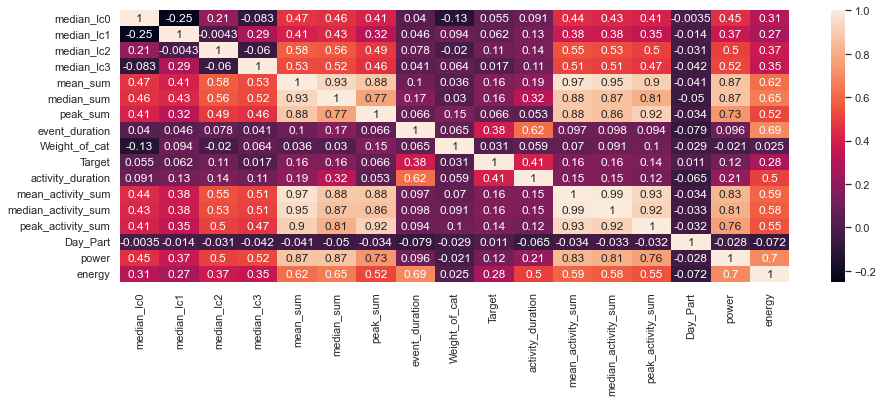

In [88]:
sns.heatmap(data,annot=True)

#### Observation
- activity duration, event duration and energy is showing strong correlation with Target

In [90]:
X=model_df.drop(['Target','Day_Part'],axis=1)
y=model_df['Target']

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

### Base Model

In [92]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=101)

In [95]:
y_test.value_counts()

1.0    1783
0.0     832
Name: Target, dtype: int64

### Logistic Regression

In [96]:
model_logi = LogisticRegression(random_state=0)

In [97]:
model_logi.fit(X_train,y_train)

LogisticRegression(random_state=0)

In [98]:
y_pred=model_logi.predict(X_test)

In [99]:
model_logi.score(X_test,y_test)

0.8003824091778202

In [100]:
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.77      0.53      0.63       832
           1       0.81      0.93      0.86      1783

    accuracy                           0.80      2615
   macro avg       0.79      0.73      0.75      2615
weighted avg       0.80      0.80      0.79      2615



<AxesSubplot:>

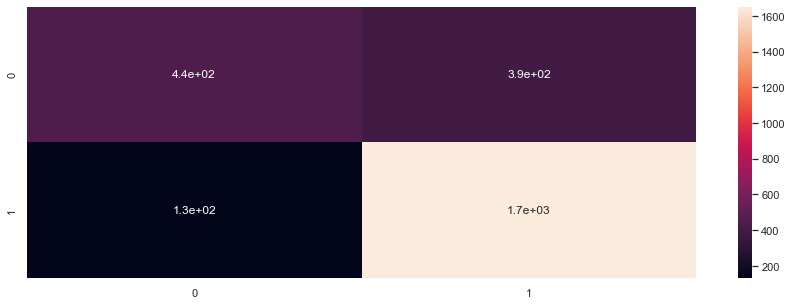

In [101]:
from sklearn import metrics
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

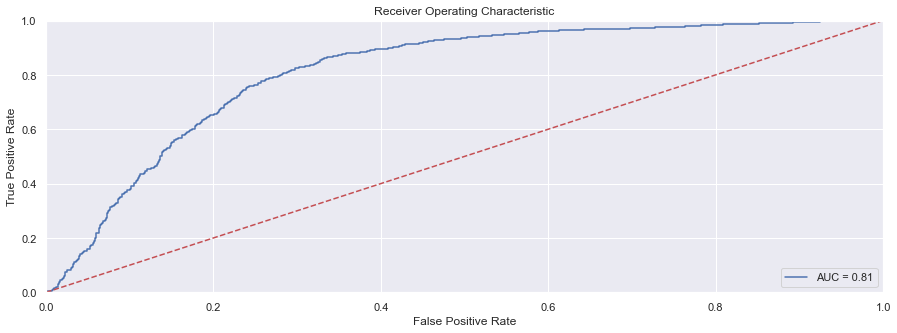

In [102]:
probs = model_logi.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Decision Tree

In [103]:
model_dt=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=8)

In [104]:
model_dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [105]:
y_pred=model_dt.predict(X_test)

In [106]:
model_dt.score(X_test,y_test)

0.832887189292543

In [107]:
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.85      0.57      0.69       832
           1       0.83      0.95      0.89      1783

    accuracy                           0.83      2615
   macro avg       0.84      0.76      0.79      2615
weighted avg       0.84      0.83      0.82      2615



<AxesSubplot:>

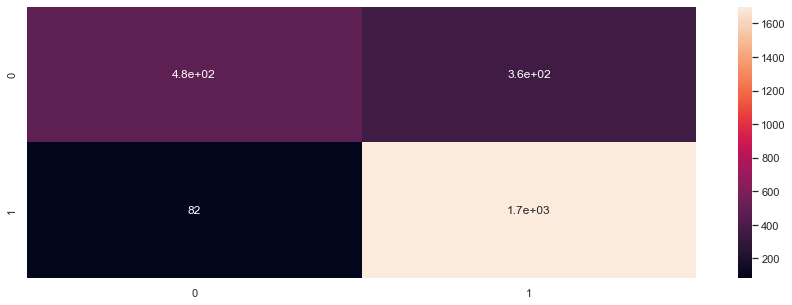

In [108]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

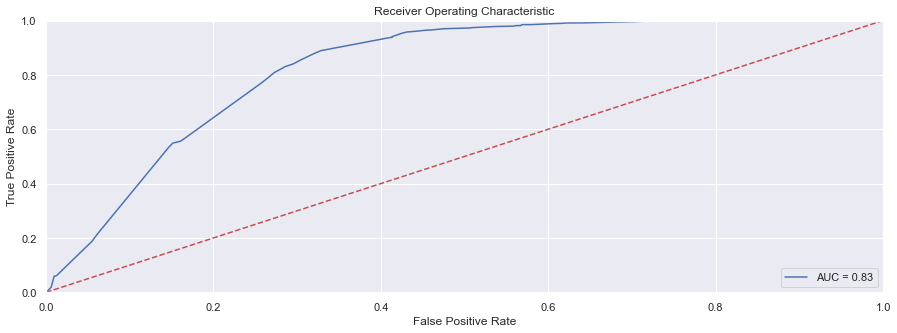

In [109]:
probs = model_dt.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random Forest

In [118]:
model_rf=RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)

In [119]:
model_rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [120]:
y_pred=model_logi.predict(X_test)

In [121]:
model_rf.score(X_test,y_test)

0.8363288718929255

<AxesSubplot:>

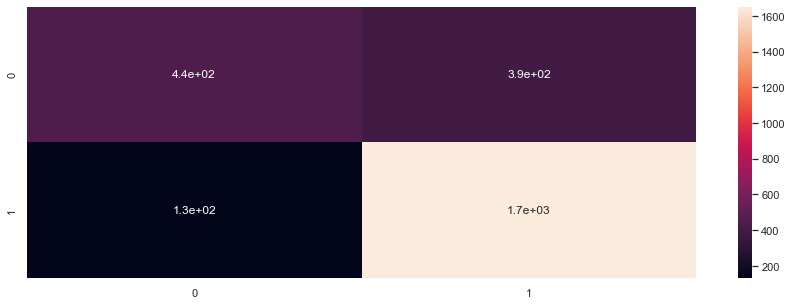

In [114]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

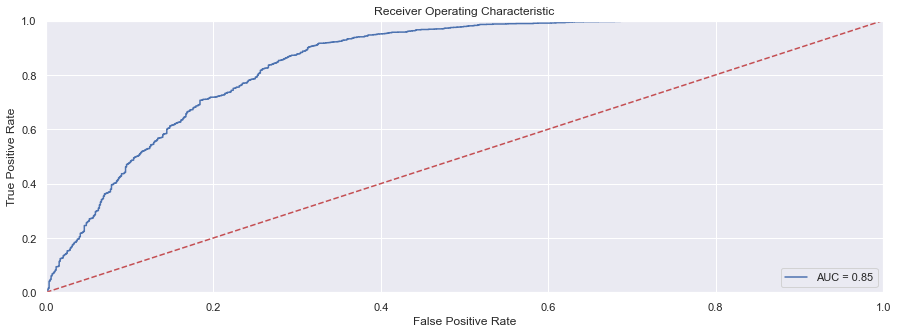

In [115]:
probs = model_rf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observations
- Implemented Logistic Regression, Decision Tree and Random Forest models
- Based on model evaluation metrics Decision Tree is giving best results